In [40]:
import pip
pip.main(['install','kplr'])

You are using pip version 8.1.2, however version 9.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


0

In [41]:
import math
import numpy as np
import kplr

#find the target KOI
client = kplr.API()
koi = client.koi(97.01)

#Get a list of light curve datasets
lcs = koi.get_light_curves(short_cadence=False)

#Open the first dataset and read it
f = lcs[0].open()
hdu_data = f[1].data
time = hdu_data["time"] # get the time of each observation
flux = hdu_data["sap_flux"] # get the flux
flux_err = hdu_data["sap_flux_err"] # get the error in the flux
f.close

Found local file: 'C:\Users\DELL\.kplr\data\lightcurves\005780885\kplr005780885-2009131105131_llc.fits'


<bound method HDUList.close of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000002574EC6FFD0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x000002574FA9F630>, <astropy.io.fits.hdu.image.ImageHDU object at 0x000002574FAE9C50>]>

In [42]:
index = np.where((time > 124)& (time < 125))
time_obs = time[index]
flux_obs = flux[index]
flux_err_obs = flux_err[index]

In [43]:
# problem 1
import numpy as np
import math

def F_com(flux):
    flux_list=[]
    a = np.mean(flux)
    b = np.std(flux)
    for i in range(0,len(flux),1):
        if (abs(flux[i]-a)/b<=2):
            flux_list.append(flux[i])
    return flux_list

#repeat 8 times to obtain Fbar
flux=flux_obs
for j in range(1,8,1):
    flux=F_com(flux)
flux_mean = sum(flux)/len(flux)
flux = flux_obs/flux_mean
flux_err = flux_err_obs/flux_mean

#find  chi square using the guessing parameters
tao = 0.1
t0 = 124.51
z = (time_obs-t0)/tao

def rect_int(integrand, lim_0, lim_1, nx):
    """rectangle rule integration.
         integrand: the function f(x) to be integrated.
         lim_0 and lim_1: lower and upper integration limits
         nx: the number of integration steps"""
    delx = (lim_1 - lim_0) / float(nx)  #rectangle width
    result = 0
    for i in np.arange(int(nx)):
        x       = lim_0 + i * delx   #the current ordinate
        f_x     = integrand(x)       #using the function provided
        result += f_x*delx           #a += 1 same as a = a + 1
    return result

def delta(p, r, z):
    """returns the value of the delta function (equation 2),
    protecting against obvious fault."""
    if (r >= z + p) or (r <= z - p):
        return 0
    elif (r + z <= p):
        return 1
    else:  #all other cases
        if (z != 0) and (r!=0): #prevent div by zero errors
            argument = (z*z - p*p + r*r) / (2.0*z*r)
        else:
            print('Either z or r vanished. z =',z,'; and r =',r,'.')
        return (1.0/math.pi) * math.acos(argument)
    
def mu(r):
    return (1-r**2)**0.5
def limb_func(r):
    return 1-(1-mu(r)**0.5)    

def flux_func(p,z,int_func,limb_func, nx):
    """return the value of the flux, using equation 1. p & z are the 
    parameters, int_func is the integration routine, limb_func is the 
    chosen limb darkening profile, and nx is the number of integration 
    steps."""
    
    # integrand for the numerator
    def numerator(r, p = p, z = z):  #default parameters allow passing data
        return limb_func(r) * (1.0 - delta(p, r, z)) * 2.0 * r
    
    # and for the denominator
    def denominator (r):
        return limb_func(r) * 2.0 * r
    
    #now do the integrations
    top    = int_func(numerator,   0.0, 1.0, nx)
    bottom = int_func(denominator, 0.0, 1.0, nx)
        
    return top/bottom

F_estimated = []
for i in range(0,len(flux),1):
    F_estimated.append(flux_func(0.0775, abs(z[i]),rect_int,limb_func, 10**3))

X_square=0
for i in range(0,len(flux),1):
    X_square = X_square + ((flux[i]-F_estimated[i])/flux_err[i])**2   

In [44]:
print("X_square=", X_square)

X_square= 464.170373532


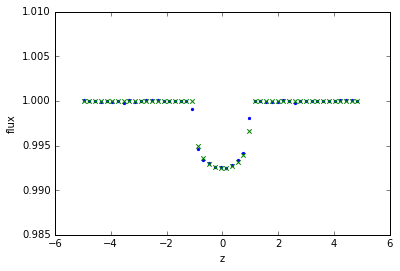

It is a good fit


In [45]:
# problem 2
import matplotlib.pyplot as plt
%matplotlib inline
p1 = plt.scatter(z, flux, marker = '.', color = 'blue')
p2 = plt.scatter(z, F_estimated, marker = 'x',color = 'green')
plt.xlabel('z')
plt.ylabel('flux')
plt.show()
print("It is a good fit")


In [46]:
N = len(flux)
M = 3
V = N-M

import numpy as np
from scipy.special import gamma
from scipy.integrate import quad,dblquad,nquad

Q = quad(lambda x:np.exp(-x)*x**(V/2-1), X_square/2,np.inf)/gamma(V/2)
print("Q =", Q)
print("p_value is too small thus it is not a good fit")

Q = [  1.75064678e-70   1.48683023e-73]
p_value is too small thus it is not a good fit


In [47]:
#problem 3
import numpy as np
tao =0.08
t0 = 124.51
tao_list = []
X_square_list = []
while tao<0.13:
    tao_list.append(tao)
    z = (time_obs-t0)/tao
    F_estimated = []
    X_square=0
    for i in range(0, len(flux), 1):
        F_estimated.append(flux_func(0.0775, abs(z[i]),rect_int,limb_func, 10**3))
        X_square = X_square + ((flux[i] - F_estimated[i])/flux_err[i])**2
    X_square_list.append(X_square)
    tao = tao+0.001
    
index = np.where(X_square_list==np.min(X_square_list))
print("minimum chi square =", X_square_list[17])
print("corresponding tao =", tao_list[17])       

minimum chi square = 245.082238281
corresponding tao = 0.09700000000000002


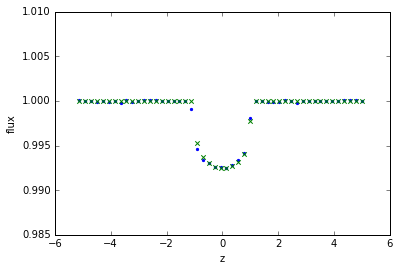

Q = [  5.72161036e-29   8.49177109e-31]
p_value is too small thus it is not a good fit


In [49]:
# plot the result
tao = 0.097
z= (time_obs-t0)/tao
t0 = 124.51
F_estimated=[]
for i in range(0, len(flux), 1):
    F_estimated.append(flux_func(0.0775, abs(z[i]),rect_int,limb_func, 10**3))
    
import matplotlib.pyplot as plt
%matplotlib inline
p1 = plt.scatter(z, flux, marker = '.', color = 'blue')
p2 = plt.scatter(z, F_estimated, marker = 'x',color = 'green')
plt.xlabel('z')
plt.ylabel('flux')
plt.show()

N = len(flux)
M = 3
V = N-M

import numpy as np
from scipy.special import gamma
from scipy.integrate import quad,dblquad,nquad

Q = quad(lambda x:np.exp(-x)*x**(V/2-1), X_square_list[17]/2,np.inf)/gamma(V/2)
print("Q =", Q)
print("p_value is too small thus it is not a good fit")

In [ ]:
#determine the one-sigma uncertainty
tao = 0.0965
t0 = 124.51
X_square_list2 = []
tao_list2 = []
while tao < 0.0975:
    tao_list2.append(tao)
    z=(time_obs-t0)/tao
    F_estimated2 = []
    X_square = 0
    for i in range(0,len(flux),1):
        F_estimated2.append(flux_func(0.0775, abs(z[i]),rect_int,limb_func, 10**3))
        X_square = X_square + ((flux[i]-F_estimated2[i])/flux_err[i])**2
    X_square_list2.append(X_square)
    tao=tao+0.00001

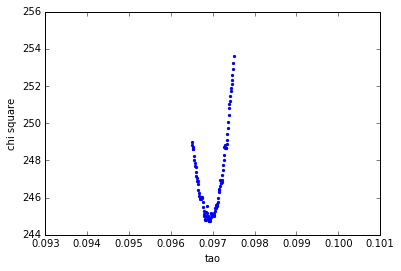

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(tao_list2, X_square_list2, marker = '.', color = 'blue')
y= X_square_list[17]+1
plt.plot(tao,y,color = 'green')
plt.xlabel('tao')
plt.ylabel('chi square')
plt.show()

In [ ]:
index = np.where(X_square_list2 < X_square_list[17]+1)
index

In [33]:
u = tao_list2[63]-tao_list2[19]
print("one_sigma uncertainty =", u)

one_sigma uncertainty = 0.0004399999999998294


In [34]:
#problem 4
import pip
pip.main(['install','emcee'])

  Running setup.py bdist_wheel for emcee: started
  Running setup.py bdist_wheel for emcee: finished with status 'done'
  Stored in directory: C:\Users\DELL\AppData\Local\pip\Cache\wheels\4e\29\27\417d1cb44565c479884d659a93edb24ff031d470db2be3b9dd
Successfully built emcee


You are using pip version 8.1.2, however version 9.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


0

In [ ]:
import emcee